In [26]:
!pip install causalimpact


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [27]:
from causalimpact import CausalImpact


In [28]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima_process import arma_generate_sample
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15, 6)

np.random.seed(1)

x1 = arma_generate_sample(ar=[0.999], ma=[0.9], nsample=100) + 100
y = 1.2 * x1 + np.random.randn(100)

y[71:100] = y[71:100] + 10
data = pd.DataFrame(np.array([y, x1]).T, columns=["y","x1"])

In [29]:
data.shape
data.head()

,y,x1
0,121.308920,101.463374
1,120.563149,99.448868
2,119.832495,99.524170
3,119.433612,99.033362
4,119.840664,100.779647


<Axes: >

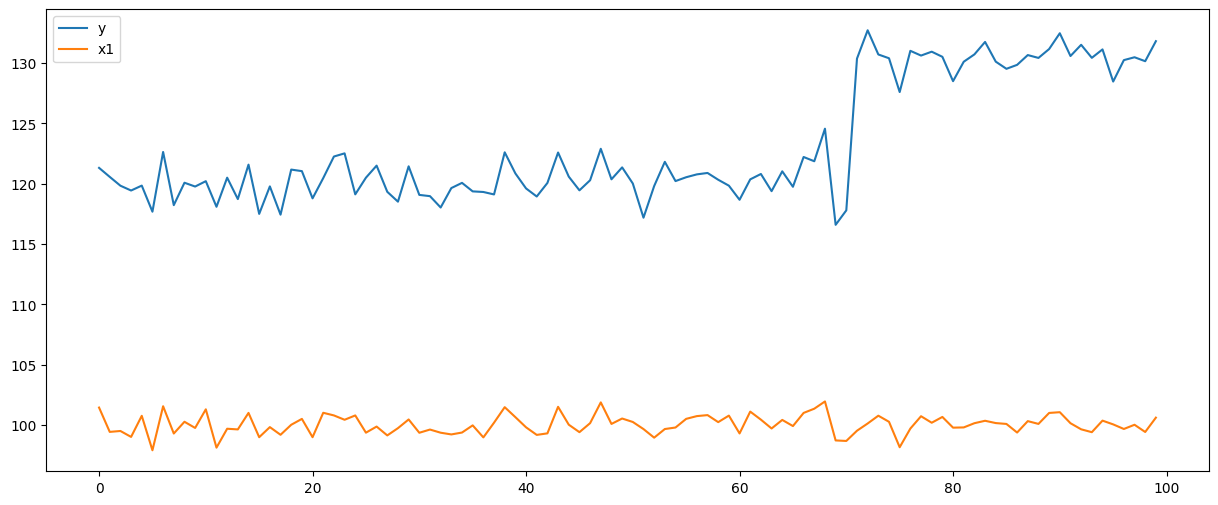

In [30]:
data.plot()

In [31]:
pre_period = [0,69]
post_period = [71,99]

In [32]:
impact = CausalImpact(data, pre_period, post_period)

In [33]:
impact.run()

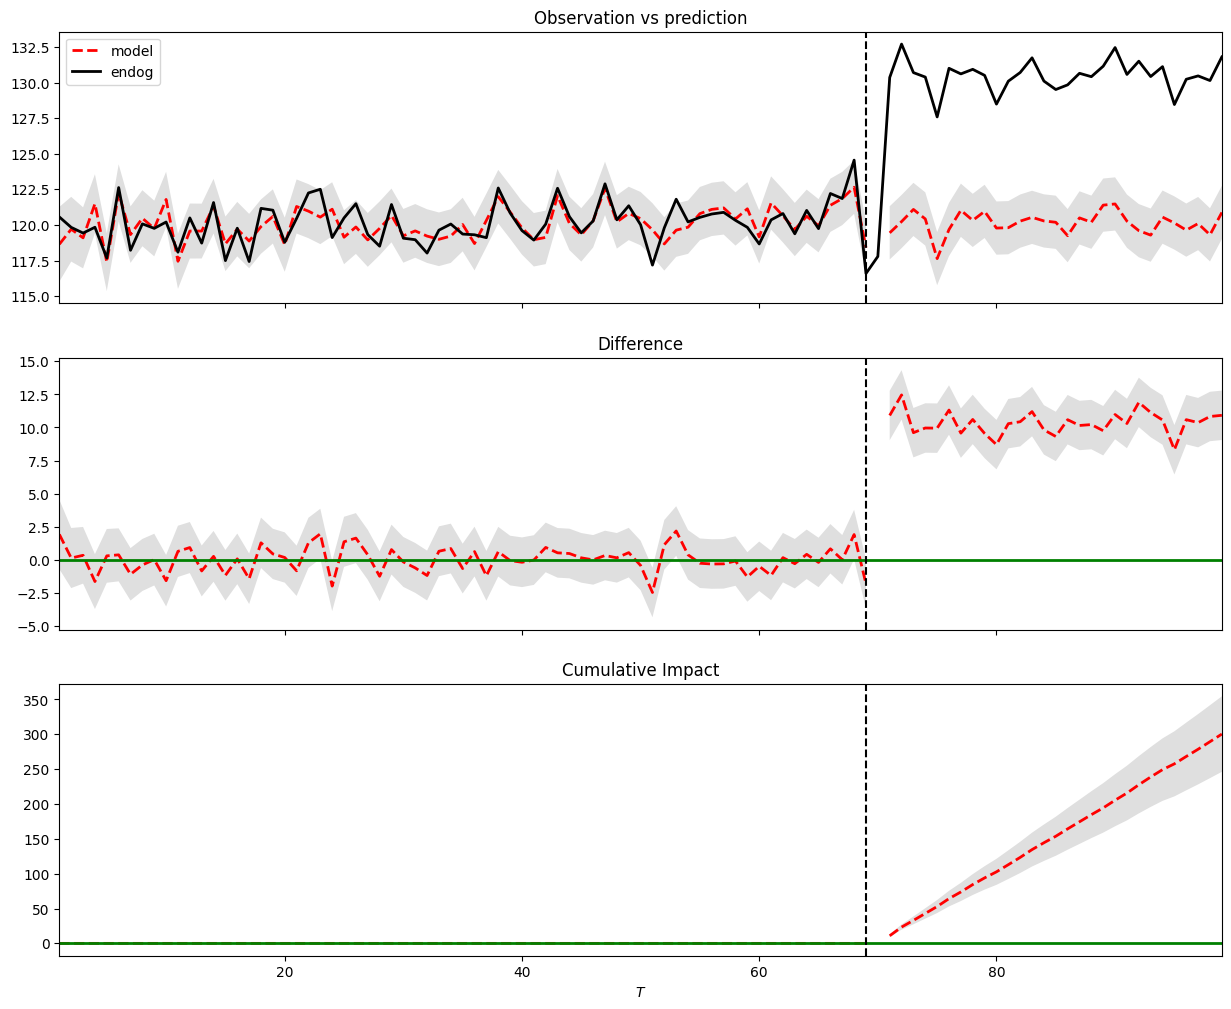

In [34]:
impact.plot()

In [35]:
date_range = pd.date_range(start="2014-01-01", periods=100)
ts_data = data.copy()
ts_data.index = date_range
ts_data.head()

,y,x1
2014-01-01,121.308920,101.463374
2014-01-02,120.563149,99.448868
2014-01-03,119.832495,99.524170
2014-01-04,119.433612,99.033362
2014-01-05,119.840664,100.779647


In [36]:
ts_pre_period = [pd.to_datetime(date) for date in ["2014-01-01", "2014-03-12"]]
ts_post_period = [pd.to_datetime(date) for date in ["2014-03-13", "2014-04-10"]]

In [37]:
ts_impact = CausalImpact(ts_data, ts_pre_period, ts_post_period)
ts_impact.run()

In [38]:
ts_impact.inferences.head(2)


,response,cum_response,point_pred,point_pred_lower,point_pred_upper,cum_pred,cum_pred_lower,cum_pred_upper,point_effect,point_effect_lower,point_effect_upper,cum_effect,cum_effect_lower,cum_effect_upper
2014-01-01,121.308920,121.30892,121.994854,-2804.815502,3048.805211,121.994854,-2804.815502,3048.805211,-0.685934,2926.124423,-2927.496290,0.0,0.0,0.0
2014-01-02,120.563149,241.87207,118.618185,116.007655,121.228715,240.613039,-2688.807847,3170.033926,1.944964,4.555494,-0.665566,0.0,0.0,0.0


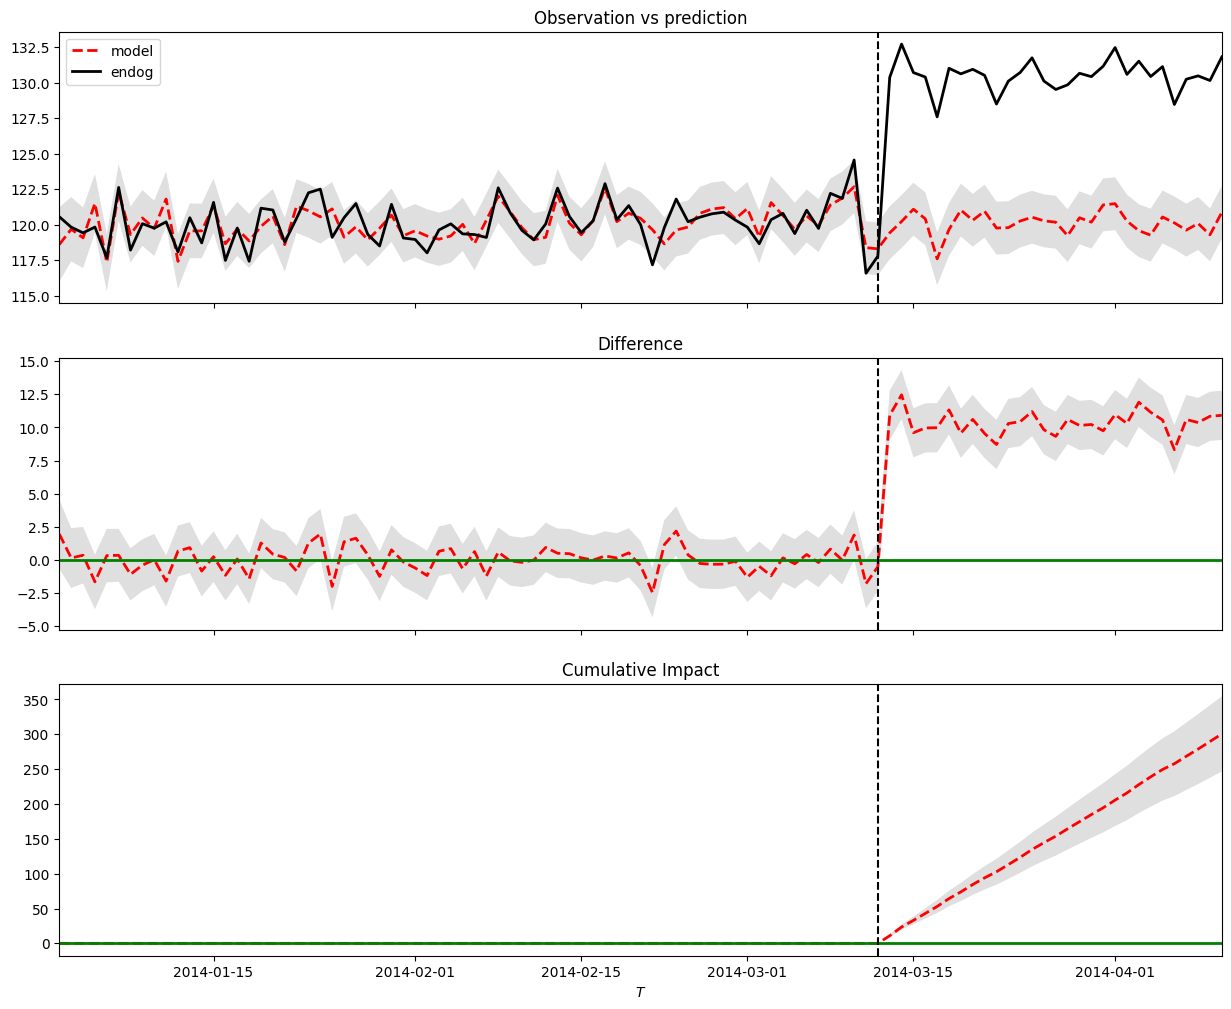

In [39]:
ts_impact.plot()

In [40]:
ts_impact.summary()


                              Average     Cumulative
Actual                            130           3784
Predicted                         120           3484
95% CI                     [118, 122]   [3430, 3538]
                                                    
Absolute Effect                    10            300
95% CI                        [12, 8]     [354, 246]
                                                    
Relative Effect                  8.6%           8.6%
95% CI                  [10.2%, 7.1%]  [10.2%, 7.1%]
                                                    
P-value                          0.0%               
Prob. of Causal Effect         100.0%               


In [41]:
ts_impact.summary(output="report")

During the post-intervention period, the response             variable had an average value of             approx. 130.
By contrast, in  the absence of an intervention, we would have expected an average response of 120. The 95% interval of
this counterfactual prediction is [118, 122]. Subtracting this prediction from the observed response yields an estimate
of the causal effect the intervention had on the response variable. This effect is 10 with a 95% interval of [12, 8].
For a discussion of the significance of this effect, see below.


 Summing up the individual data points during the post-intervention period (which can only sometimes be meaningfully
interpreted), the response variable had an overall value of 3784.  By contrast, had  the intervention not taken place,
we would have expected a sum of 3484. The 95% interval of this prediction is [3430, 3538]


 The above results are given in terms of absolute numbers. In relative terms, the response variable showed  an increase
of  8.6%

In [42]:
ts_impact = CausalImpact(data, pre_period, post_period, model_args={"nseasons":7})
ts_impact.run()

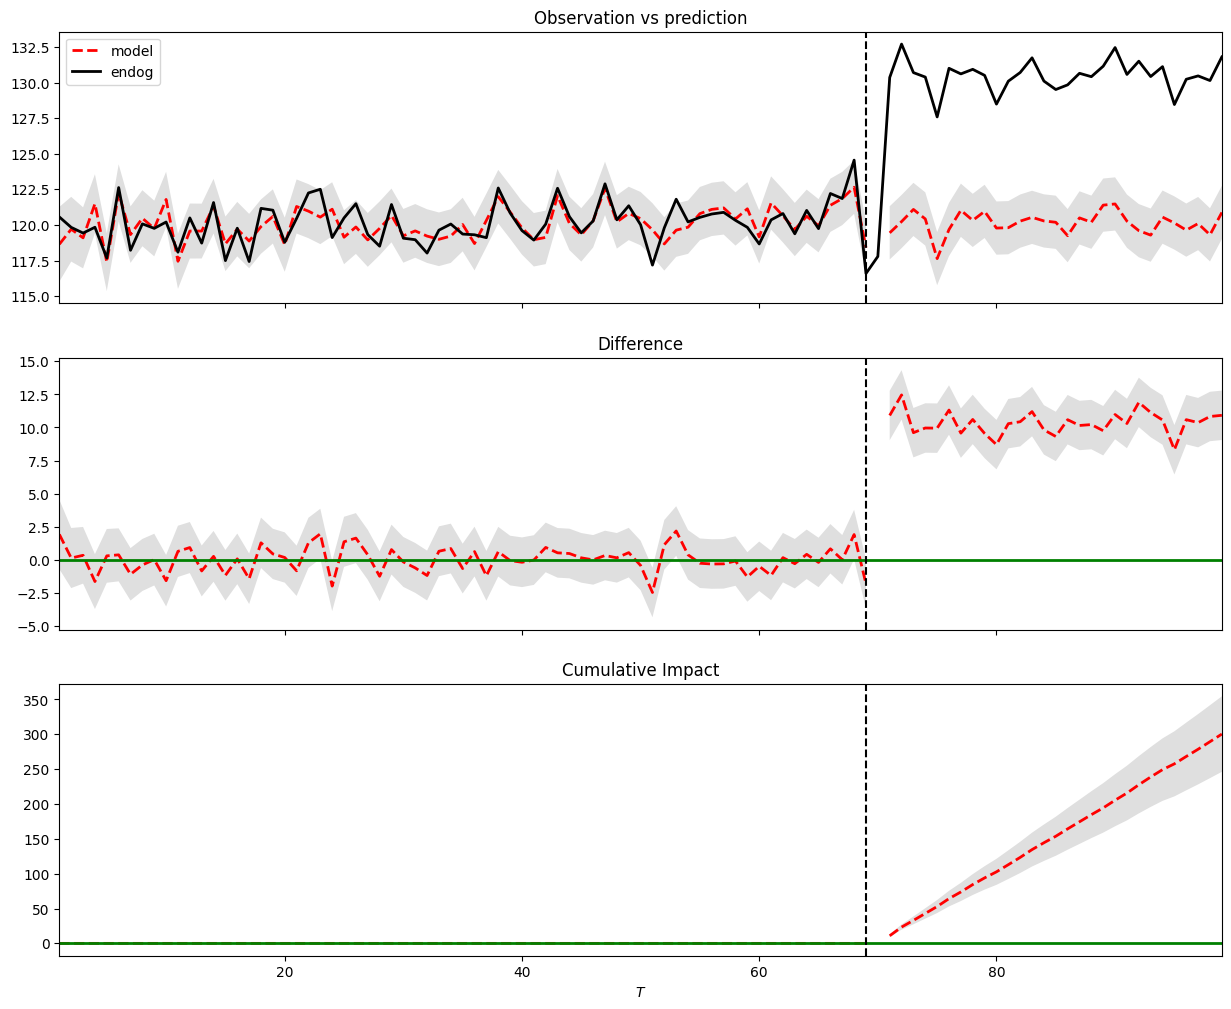

In [43]:
ts_impact.plot()


In [44]:
post_period = [70,100]
post_period_response = y[post_period[0]:post_period[1]].copy()
y[post_period[0]:post_period[1]] = np.nan

In [45]:
from statsmodels.tsa.statespace.structural import UnobservedComponents
ucm_model = UnobservedComponents(endog=y, level="llevel")
custom_impact = CausalImpact(ucm_model=ucm_model, post_period_response=post_period_response)
custom_impact.run()

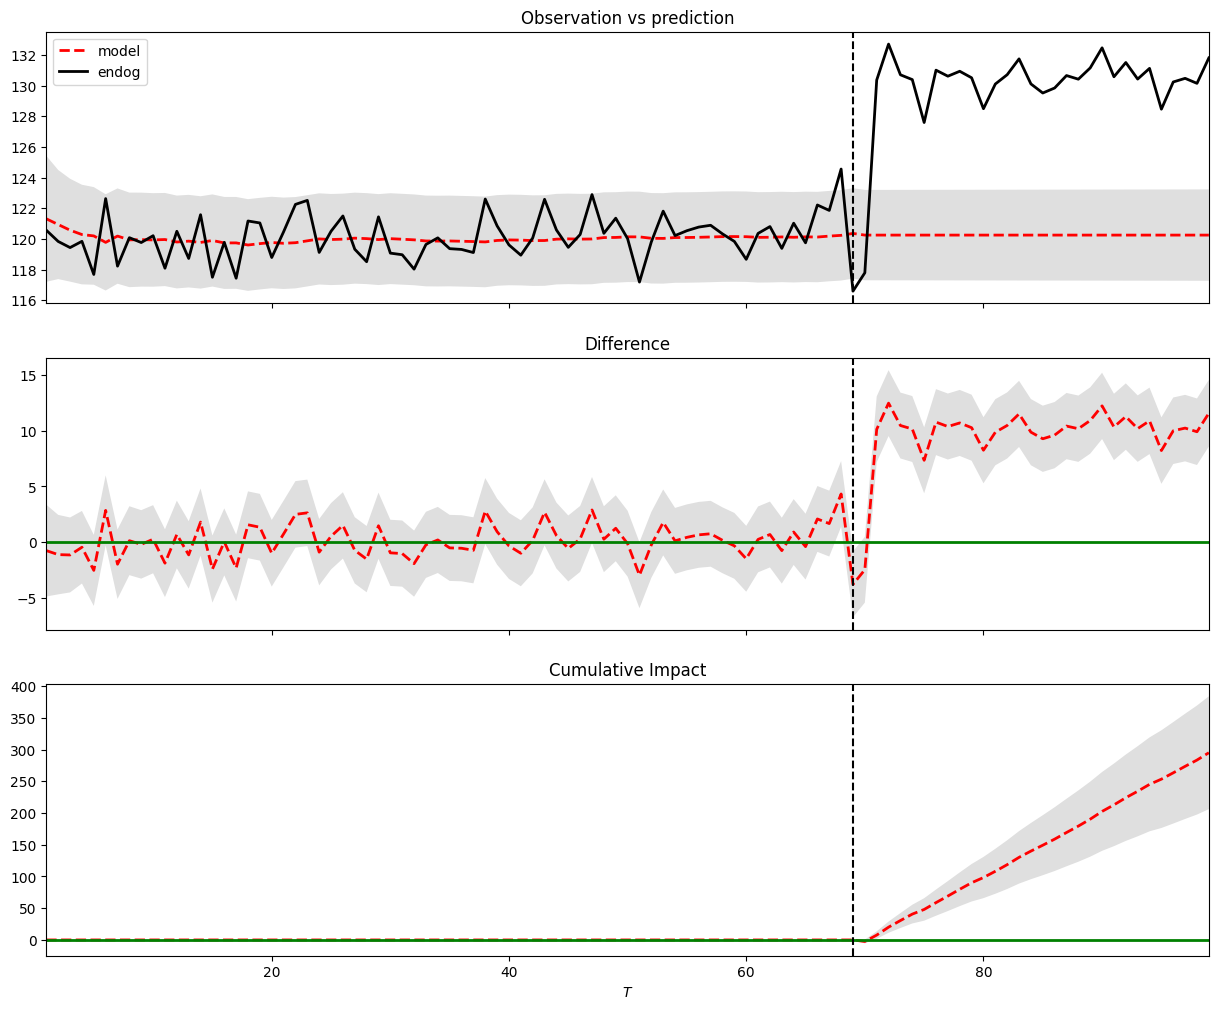

In [46]:
custom_impact.plot()



In [47]:
custom_impact.inferences.head()

,response,cum_response,point_pred,point_pred_lower,point_pred_upper,cum_pred,cum_pred_lower,cum_pred_upper,point_effect,point_effect_lower,point_effect_upper,cum_effect,cum_effect_lower,cum_effect_upper
0,121.308920,121.308920,0.000000,-1959.966134,1959.966134,0.000000,-1959.966134,1959.966134,121.308920,2081.275055,-1838.657214,0.0,0.0,0.0
1,120.563149,241.872070,121.308654,117.202395,125.414913,121.308654,-1842.763739,2085.381048,-0.745505,3.360754,-4.851764,0.0,0.0,0.0
2,119.832495,361.704565,120.935753,117.379151,124.492354,242.244407,-1725.384588,2209.873402,-1.103257,2.453344,-4.659859,0.0,0.0,0.0
3,119.433612,481.138177,120.567508,117.213863,123.921153,362.811915,-1608.170725,2333.794556,-1.133896,2.219749,-4.487541,0.0,0.0,0.0
4,119.840664,600.978841,120.283238,117.035651,123.530825,483.095153,-1491.135074,2457.325381,-0.442574,2.805013,-3.690161,0.0,0.0,0.0


In [48]:
bayes_impact = CausalImpact(data, pre_period, post_period, estimation="pymc", model_args={"ndraws":3000, "nburn":300})


In [49]:
bayes_impact.run()



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma2.irregular, sigma2.level, beta.x1]


Sampling 4 chains for 300 tune and 3_000 draw iterations (1_200 + 12_000 draws total) took 4005 seconds.


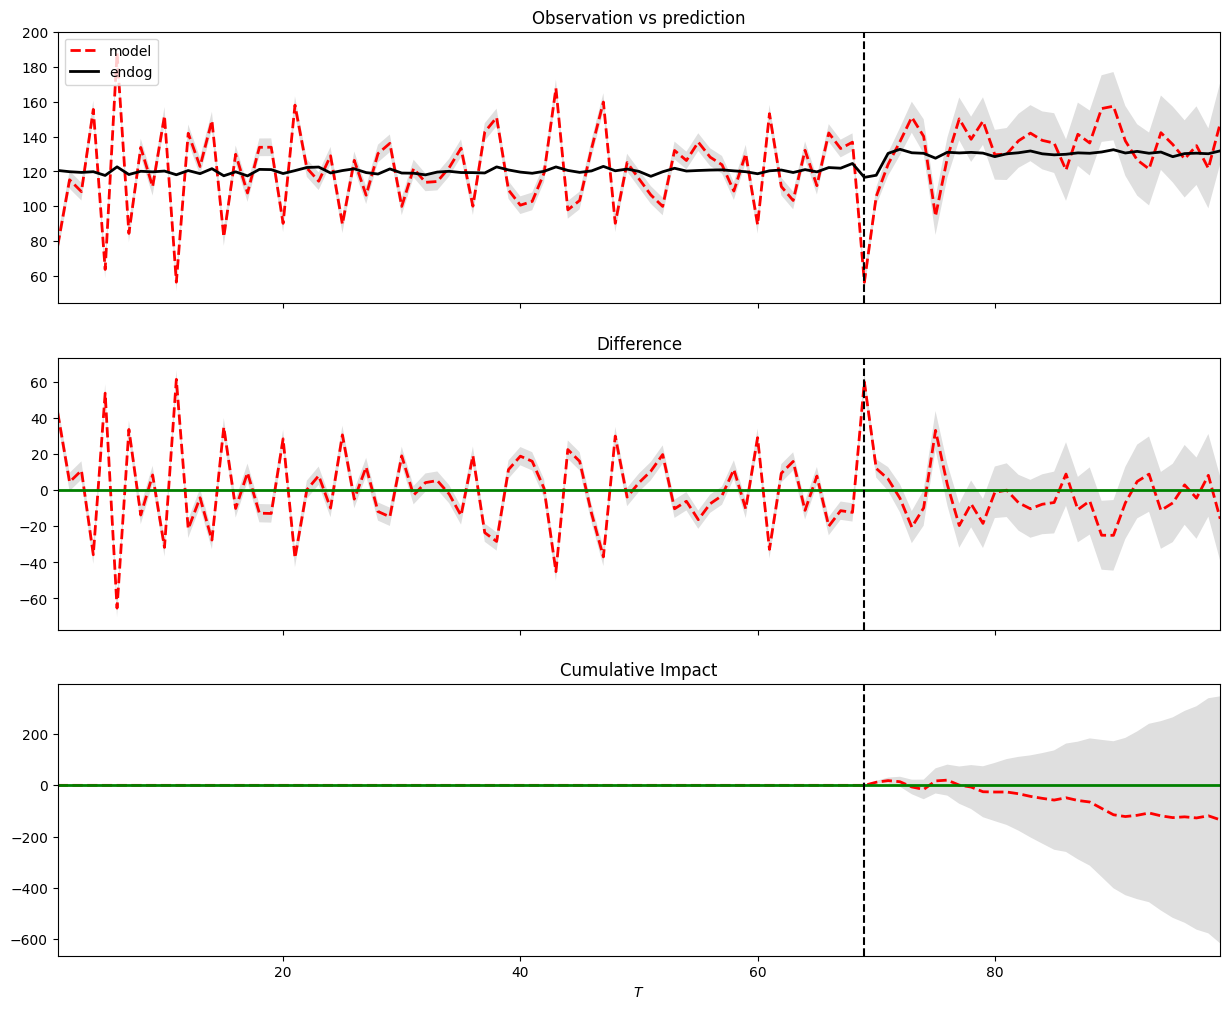

In [50]:
bayes_impact.plot()

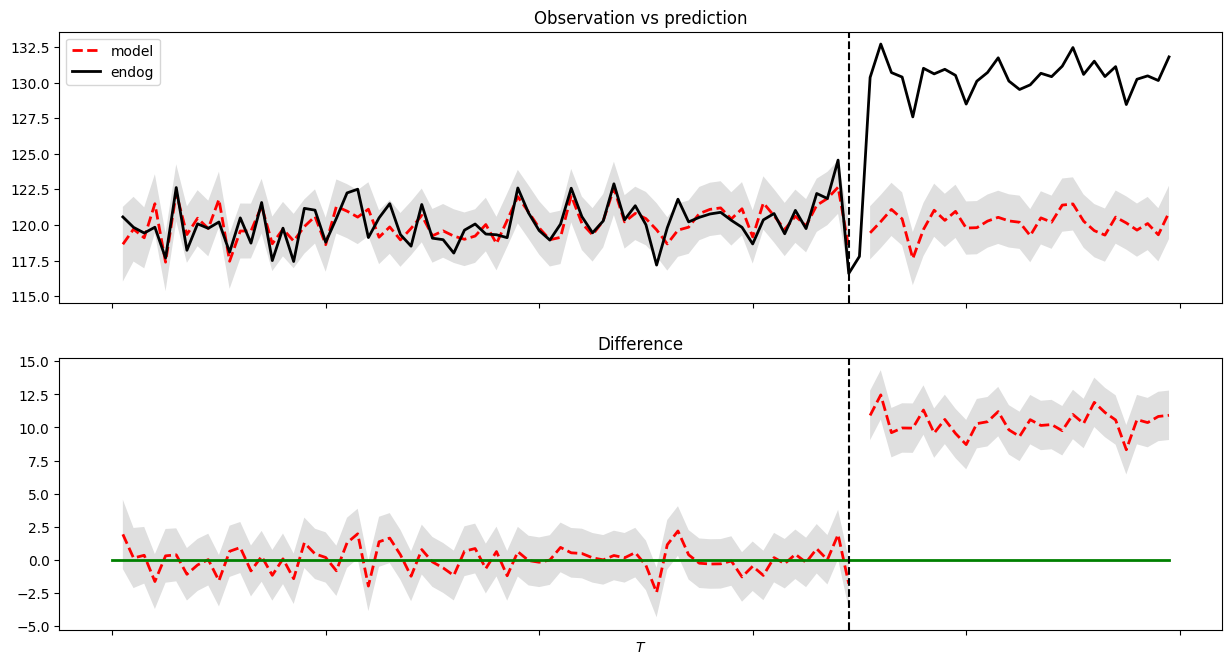

In [51]:
impact.plot(["original", "pointwise"])

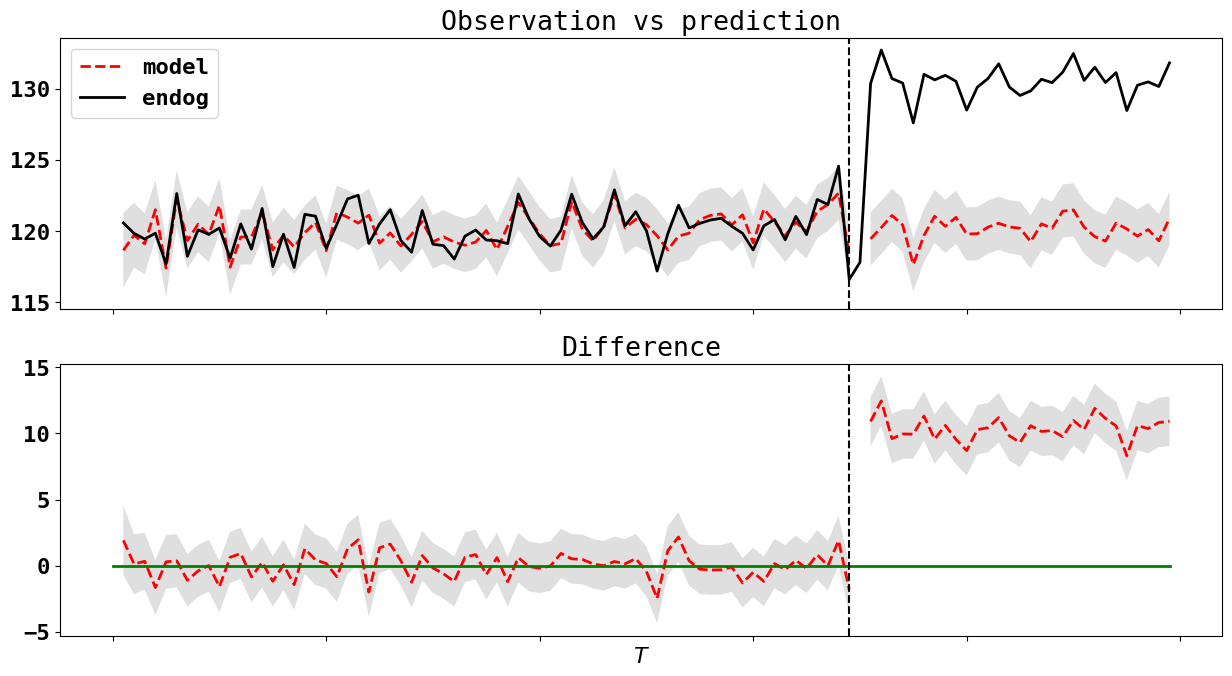

In [52]:
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)
impact.plot(["original", "pointwise"])
# reset back to normal
font = {'family' : 'sans serif',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)